# ДЗ Линейная регрессия

В данном задании мы рассмотрим набор данных об учащихся, собранный в 2006 году в одной из школ Португалии. Данные представлены в неудобном для машинного обучения виде, и содержат мусор. Ваша задача &mdash; привести их к надлежащему виду и обучить на них простую модель.

Данные состоят из четырех файлов:
- data.csv &mdash; основная таблица с информацией о учащихся
- scores.csv &mdash; список финальных оценок по одному из предметов (20-балльная шкала переведенная в проценты)
- attendance.csv &mdash; таблица посещений занятий по этому предмету
- school_support.txt &mdash; список учащихся, которым оказывается финансовая поддержка

Ваша задача &mdash; построить модель для предсказания финальных оценок исходя из всех остальных данных и проверить качество ее работы с помощью кросс-валидации. В качестве алгоритма мы будем использовать линейную регрессию

Расшифровка столбцов в data.csv для справки:
- age &mdash; возраст
- Medu &mdash; уровень образования матери (по некоторой условной шкале)
- Fedu &mdash; уровень образования отца (по некоторой условной шкале)
- traveltime &mdash; время в пути до школы (1 – < 15 мин., 2 – от 15 до 30 мин., 3 – от 30 мин. to 1 ч.
или 4 – > 1 ч.)
- studytime &mdash; время, затрачиваемое на занятия вне школы (1 – < 2 ч., 2 – от 2 до 5 ч., 3 – от 5 до 10 ч. или 4 – > 10 ч.)
- famrel &mdash; насколько хорошие отношения в семье у учащегося (по некоторой условной шкале)
- freetime &mdash; количество свободного времени вне школы (по некоторой условной шкале)
- goout &mdash; время, затрачиваемое на общение с друзьями (по некоторой условной шкале)
- Dalc &mdash; количество употребления алкоголя в учебные дни (по некоторой условной шкале)
- Walc &mdash; количество употребления алкоголя в неучебные дни (по некоторой условной шкале)
- health &mdash; уровень здоровья (по некоторой условной шкале)
- sex_M &mdash; пол: мужской (1) или женский (0)
- address_U &mdash; живет ли учащийся в городе (1) или в пригороде (0)
- famsize_LE3 &mdash; размер семьи: не больше 3 человек (1) или больше (0)
- Pstatus_T &mdash; живут ли родители вместе (1) или отдельно (0)
- nursery &mdash; посещал ли учащийся детский сад
- plans_university &mdash; планирует ли учащийся поступать в университет (-1 или 1)
- past_failures &mdash; количество неудовлетворительных оценок по другим предметам ранее (от 0 до 4)

*Примечание. Несколько признаков в данных содержат ошибки/проблемы/некорректности. Эти проблемы нужно исправить. Для
проверки &mdash; всего в данных таких проблем четыре.*

### Loading libraries
- Pandas
- NumPy
- MatPlotLib

In [1014]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

### Common functions

In [1015]:
def saveFile(data : pd.DataFrame, name : str = "modified_data.csv", indexed : bool= False):
    pd.DataFrame.to_csv(data, name, index=indexed)

### Задача 1: сломанный признак (а может и не один)
__(1 балл)__

Загрузите таблицу data.csv.

Найдите в данных сломанный признак (он не соответствует описанию) и исправьте его.

In [1016]:
df = pd.read_csv("data.csv")
df.head(10)

,age,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,Dalc,Walc,health,sex_M,address_U,famsize_LE3,Pstatus_T,nursery,plans_universitypast_failures
0,16,4,4,1,2,5,4,4.0,1.0,2.0,5,1,1,0,1,1,10
1,17,4,4,1,1,5,3,4.0,1.0,2.0,5,0,1,0,1,1,10
2,16,1,1,2,1,4,5,5.0,2.0,4.0,5,1,0,1,1,1,10
3,18,1,2,2,1,3,4,4.0,2.0,4.0,4,1,1,0,1,0,-10
4,17,2,1,2,2,4,2,5.0,1.0,2.0,5,0,0,0,1,1,10
5,17,2,4,1,2,4,3,2.0,1.0,1.0,5,0,1,1,1,1,10
6,15,1,1,3,2,4,2,1.0,1.0,2.0,2,0,0,0,1,1,10
7,15,3,3,1,4,4,3,3.0,1.0,1.0,4,0,1,0,0,1,10
8,19,1,1,3,1,4,4,4.0,3.0,3.0,5,1,0,0,1,1,11
9,17,1,1,1,3,4,3,2.0,1.0,2.0,4,0,1,1,1,1,10


In [1017]:
def repair(data : pd.DataFrame):
    # Changing the last column with merged info
    brokenColumn = np.array(data["plans_universitypast_failures"])
    data.drop(columns=["plans_universitypast_failures"], inplace=True)
    data["plans_university"] = (brokenColumn + 5) // 10
    data["past_failures"] = abs(brokenColumn) % 10    
    return data

def fixOutliers(data : pd.DataFrame):
    # Changing outlier in ages - from date of birth to age
    data.loc[data["age"]>30, "age"] = 2006 - data["age"]

    # Changing outlier in travelTime - from minutes to particular scale
    data.loc[np.array(data["traveltime"] > 4) & np.array(data["traveltime"] < 15), "traveltime"] = 1
    data.loc[np.array(data["traveltime"] >= 15) & np.array(data["traveltime"] < 30), "traveltime"] = 2
    data.loc[np.array(data["traveltime"] >= 30) & np.array(data["traveltime"] < 60), "traveltime"] = 3
    
    return data

repaired = repair(df.copy())
repaired.head(10)

,age,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,Dalc,Walc,health,sex_M,address_U,famsize_LE3,Pstatus_T,nursery,plans_university,past_failures
0,16,4,4,1,2,5,4,4.0,1.0,2.0,5,1,1,0,1,1,1,0
1,17,4,4,1,1,5,3,4.0,1.0,2.0,5,0,1,0,1,1,1,0
2,16,1,1,2,1,4,5,5.0,2.0,4.0,5,1,0,1,1,1,1,0
3,18,1,2,2,1,3,4,4.0,2.0,4.0,4,1,1,0,1,0,-1,0
4,17,2,1,2,2,4,2,5.0,1.0,2.0,5,0,0,0,1,1,1,0
5,17,2,4,1,2,4,3,2.0,1.0,1.0,5,0,1,1,1,1,1,0
6,15,1,1,3,2,4,2,1.0,1.0,2.0,2,0,0,0,1,1,1,0
7,15,3,3,1,4,4,3,3.0,1.0,1.0,4,0,1,0,0,1,1,0
8,19,1,1,3,1,4,4,4.0,3.0,3.0,5,1,0,0,1,1,1,1
9,17,1,1,1,3,4,3,2.0,1.0,2.0,4,0,1,1,1,1,1,0


### Задача 2: пропуски в данных 
__(1 балл)__

Проверьте, есть ли в данных пропуски (значения NaN). Замените все пропущенные значения на среднее значение этого признака по столбцу.

*Hint: изучите в pandas функции loc, isnull, а также передачу булевых массивов в качестве индексов.*

In [1018]:
def fillNa(data : pd.DataFrame):
    for i in data.columns:
        data.fillna({i: data[i].median()}, inplace=True)
    return data

filledNa = fillNa(repaired.copy())
filledNa.head(10)

,age,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,Dalc,Walc,health,sex_M,address_U,famsize_LE3,Pstatus_T,nursery,plans_university,past_failures
0,16,4,4,1,2,5,4,4.0,1.0,2.0,5,1,1,0,1,1,1,0
1,17,4,4,1,1,5,3,4.0,1.0,2.0,5,0,1,0,1,1,1,0
2,16,1,1,2,1,4,5,5.0,2.0,4.0,5,1,0,1,1,1,1,0
3,18,1,2,2,1,3,4,4.0,2.0,4.0,4,1,1,0,1,0,-1,0
4,17,2,1,2,2,4,2,5.0,1.0,2.0,5,0,0,0,1,1,1,0
5,17,2,4,1,2,4,3,2.0,1.0,1.0,5,0,1,1,1,1,1,0
6,15,1,1,3,2,4,2,1.0,1.0,2.0,2,0,0,0,1,1,1,0
7,15,3,3,1,4,4,3,3.0,1.0,1.0,4,0,1,0,0,1,1,0
8,19,1,1,3,1,4,4,4.0,3.0,3.0,5,1,0,0,1,1,1,1
9,17,1,1,1,3,4,3,2.0,1.0,2.0,4,0,1,1,1,1,1,0


### Задача 3: нормализация данных
__(1 балл)__

Нормализуйте данные любым способом

In [1019]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalizeMinMax(data : pd.DataFrame):
    data[data.columns] = MinMaxScaler().fit_transform(data[data.columns])
    return data

def normalizeStandart(data : pd.DataFrame):
    data[data.columns] = StandardScaler().fit_transform(data[data.columns])
    return data

normalized = normalizeMinMax(filledNa.copy())
normalized.head(10)

,age,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,Dalc,Walc,health,sex_M,address_U,famsize_LE3,Pstatus_T,nursery,plans_university,past_failures
0,0.000506,1.00,1.00,0.000000,0.333333,1.00,0.75,0.75,0.00,0.25,1.00,1.0,1.0,0.0,1.0,1.0,1.0,0.000000
1,0.001012,1.00,1.00,0.000000,0.000000,1.00,0.50,0.75,0.00,0.25,1.00,0.0,1.0,0.0,1.0,1.0,1.0,0.000000
2,0.000506,0.25,0.25,0.020408,0.000000,0.75,1.00,1.00,0.25,0.75,1.00,1.0,0.0,1.0,1.0,1.0,1.0,0.000000
3,0.001518,0.25,0.50,0.020408,0.000000,0.50,0.75,0.75,0.25,0.75,0.75,1.0,1.0,0.0,1.0,0.0,0.0,0.000000
4,0.001012,0.50,0.25,0.020408,0.333333,0.75,0.25,1.00,0.00,0.25,1.00,0.0,0.0,0.0,1.0,1.0,1.0,0.000000
5,0.001012,0.50,1.00,0.000000,0.333333,0.75,0.50,0.25,0.00,0.00,1.00,0.0,1.0,1.0,1.0,1.0,1.0,0.000000
6,0.000000,0.25,0.25,0.040816,0.333333,0.75,0.25,0.00,0.00,0.25,0.25,0.0,0.0,0.0,1.0,1.0,1.0,0.000000
7,0.000000,0.75,0.75,0.000000,1.000000,0.75,0.50,0.50,0.00,0.00,0.75,0.0,1.0,0.0,0.0,1.0,1.0,0.000000
8,0.002024,0.25,0.25,0.040816,0.000000,0.75,0.75,0.75,0.50,0.50,1.00,1.0,0.0,0.0,1.0,1.0,1.0,0.333333
9,0.001012,0.25,0.25,0.000000,0.666667,0.75,0.50,0.25,0.00,0.25,0.75,0.0,1.0,1.0,1.0,1.0,1.0,0.000000


### Задача 4: кросс-валидация для исходных данных
__(1 балл)__

Загрузите файл scores.csv и протестируйте, как линейная регрессия предсказывает ответ сейчас (с помощью кросс-валидации).

Кроссвалидацию сделайте по 4 разбивкам. Выведите качество в каждом их разбиений.

*Hint: воспользуйтесь sklearn.linear_model и sklearn.model_selection.*

In [1020]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

scores = pd.read_csv("scores.csv")

def crossVal(x : pd.DataFrame, y : np.array = scores,  toPrint : bool = True):
    score = cross_val_score(LinearRegression(), x, y, cv = KFold(n_splits=4, shuffle=True, random_state=1488))
    if toPrint:
        print(f"Quality:")
        i = 1
        for val in score:
            print(f"Fold №{i}: {val * 100.0:.2f}%")
            i+=1
        print(f"Mean quality: {score.mean() * 100.0:.2f}%")
    return score.mean() * 100.0

crossVal(normalized)

Quality:
Fold №1: 30.13%
Fold №2: 21.06%
Fold №3: 19.93%
Fold №4: 26.75%
Mean quality: 24.47%


np.float64(24.46577620573059)

### Задача 5: полные данные
__(2 балла)__

Воспользуйтесь файлами attendance.csv и school_support.txt для того, чтобы добавить новые признаки в данные. Желательно по максимуму использовать возможности pandas для упрощения преобразований.

school_suport число в строке значит что i-ый школьник из исходной таблицы получал мат помощь (обратите внимание что строк в файле меньше, подумайте как правильно импортировать данные)

Добавьте данные таким образом, чтобы качество выросло

In [1021]:
def addData(data : pd.DataFrame):
    # Attendance
    attendance = pd.read_csv("attendance.csv", sep=";")
    data["attendance"] = attendance.count(1).max() - (attendance.count(1))

    # School support
    x = pd.read_table("school_support.txt", header=None)
    data["school_support"] = 0
    data.loc[x[0], "school_support"] = 1

    return data

added = addData(filledNa.copy())
added_normalized = normalizeMinMax(added.copy())
crossVal(added_normalized)

Quality:
Fold №1: 30.75%
Fold №2: 21.77%
Fold №3: 20.79%
Fold №4: 25.94%
Mean quality: 24.81%


np.float64(24.81088769238384)

### Задача 6: борьба с выбросами
__(1.5 балла)__

Качество предсказания может ухудшаться, если в данных присутствуют корректные значения признаков (с точки зрения чтения данных и применения методов), но не соответствующие реальным объектам. Например, данные могли быть введены в неверном формате, а потом слишком грубо приведены к общему виду, из-за чего ошибка не была замечена.
Попробуем от такого избавиться &mdash; а для этого такие объекты нужно сначала найти. Конечно, нам еще недоступны многие продвинутые способы, но давайте попробуем обойтись простыми.

Первый способ это сделать &mdash; посмотреть для каждого признака на распределение его значений и проверить крайние значения на правдоподобность. (постройте гистограммы для признаков, как минимум для подозрительных)

*Hint 1: используйте функцию DataFrame.hist*

*Hint 2: в описании датасета выше есть информация, необходимая для восстановления правильных значений*

Quality:
Fold №1: 31.12%
Fold №2: 20.80%
Fold №3: 20.57%
Fold №4: 29.94%
Mean quality: 25.61%


np.float64(25.607888054411276)

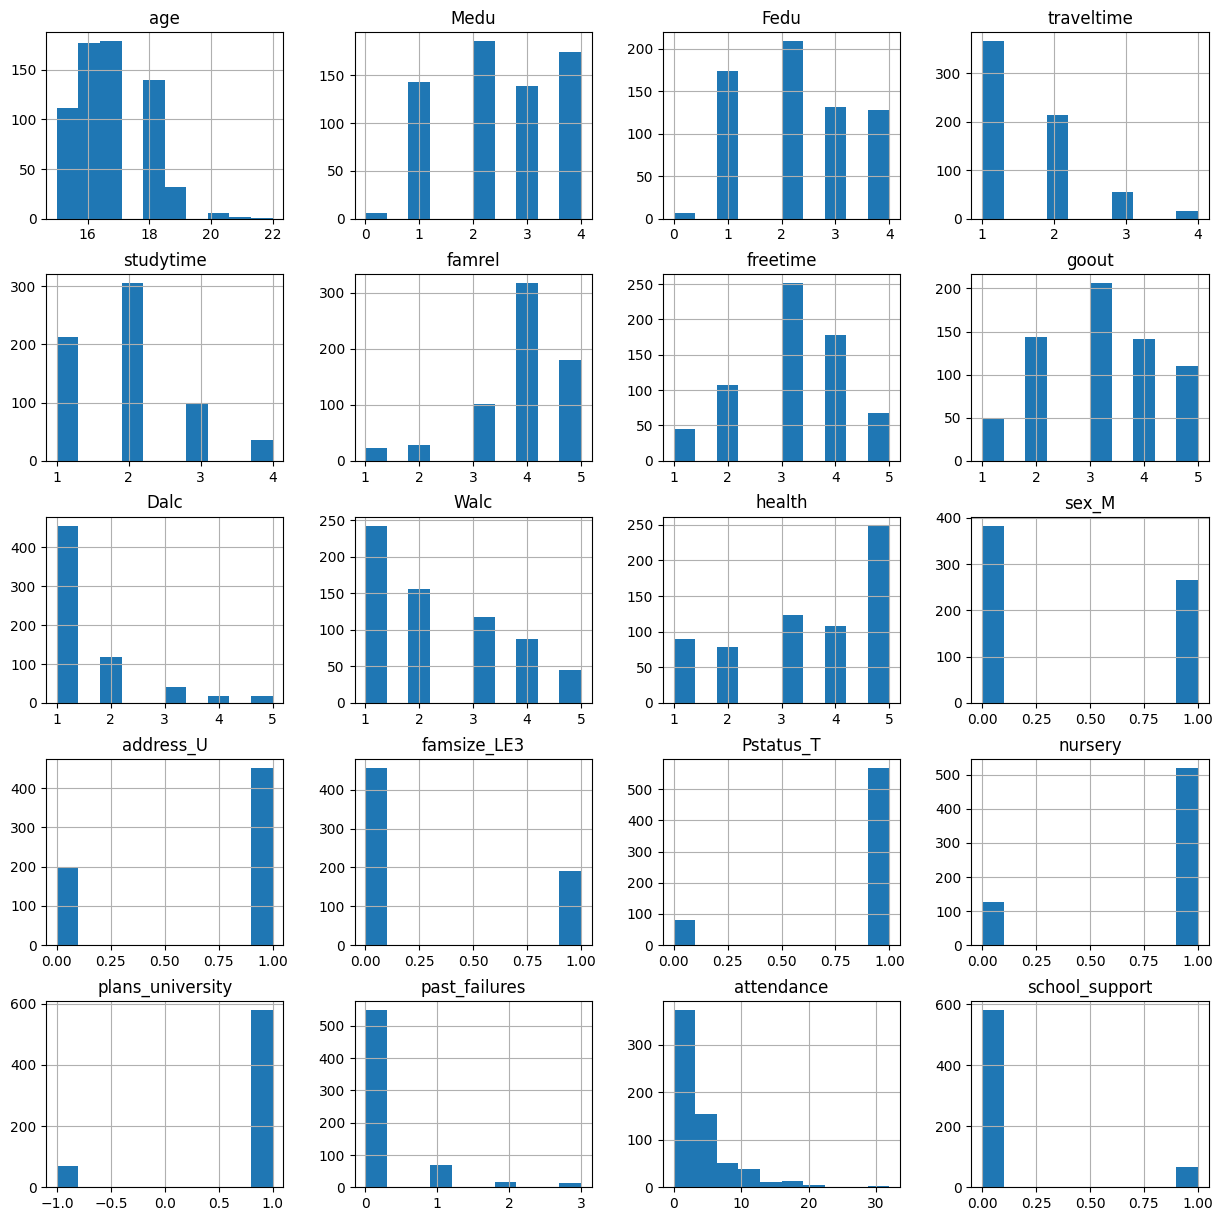

In [1022]:
added_fixed = fixOutliers(added.copy())
added_fixed.hist(figsize=(15, 15), column=added_fixed.columns)

added_fixed_normalized = normalizeMinMax(added_fixed)
crossVal(added_fixed_normalized)

__(1.5 балла)__

Другой простой способ найти выбросы &mdash; сделать предсказание и посчитать ошибку на каждом объекте по отдельности и посмотреть на объекты с наибольшей ошибкой. Обучите линейную регрессию (функция fit) и для каждого объекта посчитайте среднеквадратичное отклонение. Постройте гистограмму распределения ошибок. Посмотрите на гистограмму и удалите из выборки те объекты на которых ошибка слишком большая.

Обратите внимание, что просто удалять все объекты с высокой ошибкой нельзя &mdash; это, конечно, хороший способ добиться меньшей ошибки (на данной выборке), но одновременно вы ухудшите обобщающую способность алгоритма. Вместо этого вам нужно найти однозначно ошибочные записи и их исправить.

*Hint: возможно, все проблемы уже были найдены первым способом; для проверки &mdash; в сумме здесь нужно исправить 3 проблемы.*

Для поиска ошибки на одном отдельном обьекте придётся обучить линейную регрессию руками. Частичный пример, допишите код. Постройте гистограмму распределения ошибок

Mean quality 30.88%
Rows deleted: 29


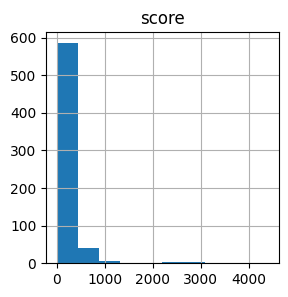

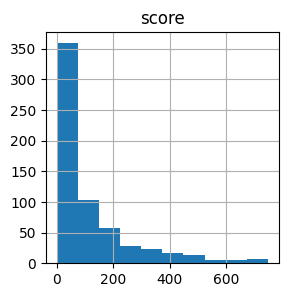

In [1023]:
data = added_fixed.copy()
result = pd.read_csv("scores.csv")

regression = LinearRegression().fit(data, result)
prediction = regression.predict(data)
error = (prediction - result)**2 #simple error - square error
error.hist(figsize=(3, 3))

newData = data.copy()
newRes = result.copy()

e = 750

cnt = np.array(np.where(error["score"] > e)).shape[1]

newData = newData[error["score"] < e]
newRes = newRes[error["score"] < e]

newError = (regression.predict(newData) - newRes) ** 2
newError.hist(figsize=(3, 3))

print(f"Mean quality {crossVal(newData, newRes, toPrint=False):.2f}%")
print(f"Rows deleted: {cnt}")

### Финальное предсказание и отчёт (1 балл)

Проведите предсказание еще раз и сравните качество с исходным. Запишите свои наблюдения - как изменялось качество обучения модели при использовании разных модификаций данных. 

In [1024]:
last = crossVal(newData, newRes, toPrint=False)
first = crossVal(normalizeMinMax(fillNa(df)), toPrint=False)
print(f"The quality improved by {(last - first):.2f}%")
print()
print(f"The quality in begin: {first:.2f}%")
print(f"The quality after fixing last column: {crossVal(filledNa, toPrint=False):.2f}%")
print(f"The quality after normalization: {crossVal(normalized, toPrint=False):.2f}%")
print(f"The quality after adding new data: {crossVal(added_normalized, toPrint=False):.2f}%")
print(f"The quality after getting rid of outliners: {crossVal(added_fixed_normalized, toPrint=False):.2f}%")
print(f"The quality after getting rid of lines with big errors: {crossVal(newData, newRes, toPrint=False):.2f}%")

The quality improved by 14.04%

The quality in begin: 16.84%
The quality after fixing last column: 24.47%
The quality after normalization: 24.47%
The quality after adding new data: 24.81%
The quality after getting rid of outliners: 25.61%
The quality after getting rid of lines with big errors: 30.88%


## Summary
- *Fixing the last column* made a **BIG** difference. One of the main problems was it. 
- *Normalization* doesn't make any difference. 
- *New data* was useful but adding it ~~wasn't very eazy~~ was instructive. 
- *Outliners* were deleted -- *Result* got better
- *Lines with big error* made the **biggest** diffence after the first fix but it may costs us problems with other datasets
